In [1]:
from plot_utils import set_size, tex_fonts, LINEWIDTH_L_CSS as linewidth
import pickle
import scipy
from pathlib import Path
import jax.numpy as jnp
import jax.random as jr
import numpy as onp
import matplotlib.pyplot as plt
import jax
from neuralss import ss_init, ss_apply
import nonlinear_benchmarks

In [2]:
nin = 10 # state_initialization_window_length variable in the NonlinearBenchmarks jargon

In [3]:
from argparse import Namespace

cfg = {
    "nu": 1,
    "ny": 1,
    "nx": 3,
    "hidden_f": 16,
    "hidden_g": 16,
    "skip_loss": 500,
}
cfg = Namespace(**cfg)

scalers = {"f": {"lin": 1e-2, "nl": 1e-2}, "g": {"lin": 1e0, "nl": 1e0}}

In [4]:
#plt.rcParams.update(tex_fonts) # use latex fonts
plt.rcParams.update({"axes.grid": True}) 

In [5]:
#%matplotlib widget

In [6]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices("cpu")[0])

In [7]:
filename = Path("out") / "full_alldata.pkl" 
ckpt = pickle.load(open(filename, "rb"))


/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_86000/639454225.py:2: DeprecationWarning: Pickled array contains an aval with a named_shape attribute. This is deprecated and the code path supporting such avals will be removed. Please re-pickle the array.
  ckpt = pickle.load(open(filename, "rb"))


In [8]:
data_folder = "bwdataset"
data_folder = Path(data_folder)

u_test = scipy.io.loadmat(data_folder / "uval_multisine.mat")["uval_multisine"].reshape(-1, 1)
y_test = scipy.io.loadmat(data_folder / "yval_multisine.mat")["yval_multisine"].reshape(-1, 1)

u_test = u_test / 50.0
y_test = y_test / 7e-4
t_test = onp.arange(0, len(u_test)) / 750 

In [9]:
# Train the initial system state x0 in the first samples of the test set

import optax
from flax.training import train_state
from tqdm import tqdm

#x0_opt = jnp.ones((cfg.nx, ))
x0_opt = ckpt["x0"]

def loss_state(x0):
    y_hat = ss_apply(ckpt["params"], scalers, x0, u_test[:nin, :])
    loss = jnp.mean((y_test[:nin] - y_hat)**2)
    return loss

def train_x0(x0_opt, iters=100, lr=1e-2):

        opt = optax.adamw(learning_rate=lr)
        state = train_state.TrainState.create(apply_fn=loss_state, params=x0_opt, tx=opt)

        @jax.jit
        def make_step(state):
                loss, grads = jax.value_and_grad(state.apply_fn)(state.params)
                state = state.apply_gradients(grads=grads)
                return loss, state
        
        losses = jnp.empty(iters)
        for idx in (pbar := tqdm(range(iters))):
                loss, state = make_step(state)
                losses = losses.at[idx].set(loss)
                pbar.set_postfix_str(loss.item())

        return state.params, jnp.array(losses)

x0_opt, _ = train_x0(x0_opt, iters=1000, lr=1e-2)
#loss_state(x0)

100%|██████████| 1000/1000 [00:01<00:00, 948.00it/s, 2.079757613719979e-05] 


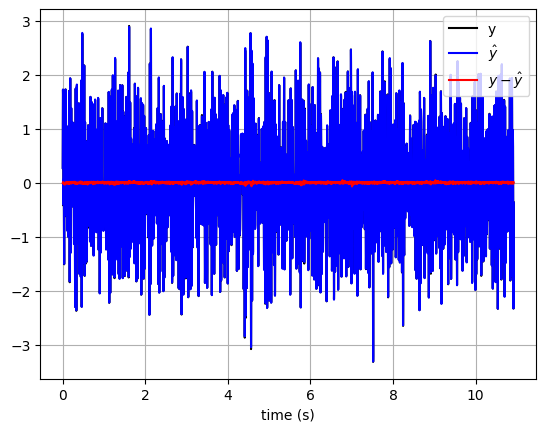

In [10]:
x0 = x0_opt
y_hat = ss_apply(ckpt["params"], scalers, x0, u_test)
#y2_hat = ss_apply(opt_vars_adam["params"], scalers, x0, u2)
plt.figure()
plt.plot(t_test, y_test, "k", label=r"y")
plt.plot(t_test, y_hat, "b", label=r"$\hat{y}$")
plt.plot(t_test, y_test - y_hat, "r", label=r"$y - \hat{y}$")
plt.xlabel("time (s)")
#plt.axvline(t_test[cfg.skip_loss], color="k") # to instead skip first samples from the loss
#plt.ylim([-4, 4])
#plt.xlim([5, 6])
plt.legend(loc="upper right")
Path("fig").mkdir(exist_ok=True)
plt.savefig(Path("fig") / "full_order_prediction.pdf")

In [11]:
fit_full = nonlinear_benchmarks.error_metrics.fit_index(y_test[cfg.skip_loss:], y_hat[cfg.skip_loss:])
rmse_full = nonlinear_benchmarks.error_metrics.RMSE(y_test[cfg.skip_loss:], y_hat[cfg.skip_loss:])*7e-4 * 1e6

#fit_full = nonlinear_benchmarks.error_metrics.fit_index(y_test, y_hat)
#rmse_full = nonlinear_benchmarks.error_metrics.RMSE(y_test, y_hat)*7e-4 * 1e6
fit_full, rmse_full # (Array([98.54584449], dtype=float64), array([0.96720211]))
print(f"Fit index: {fit_full[0]:.2f} %")
print(f"RMSE: {rmse_full[0]:.2f}e-6")

Fit index: 98.91 %
RMSE: 7.26e-6


In [12]:
#w, v = onp.linalg.eigh(onp.array(data["H"]))#[:-3, :-3])
w, v = jnp.linalg.eigh(ckpt["H"][:-3, :-3])#[:-3, :-3])
w, v = jnp.linalg.eigh(ckpt["H"])
w = w[::-1] # eigvals
v = v[:, ::-1] # eigvecs

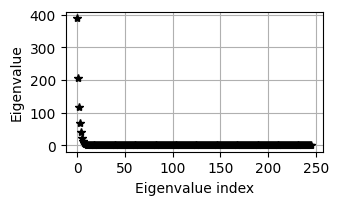

In [13]:
fig, ax = plt.subplots(1, 1, figsize=set_size(linewidth, fraction=1.0))
#plt.title("Hessian eigenvalues")
plt.plot(w[1:], "k*")
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.tight_layout()
plt.savefig(Path("fig") / "hessian_eigenvalues.pdf")
